In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Dropdown(description='State:', options=([1.0, 39.11870881130144, 117.18836803160956], [2.0, 39.136042, 117.203…

User:: 012 , Month:: 200811 ,Known State, Latitude and Longitude:: 6.0,39.982158861485054,116.32804767783807 at hour 0


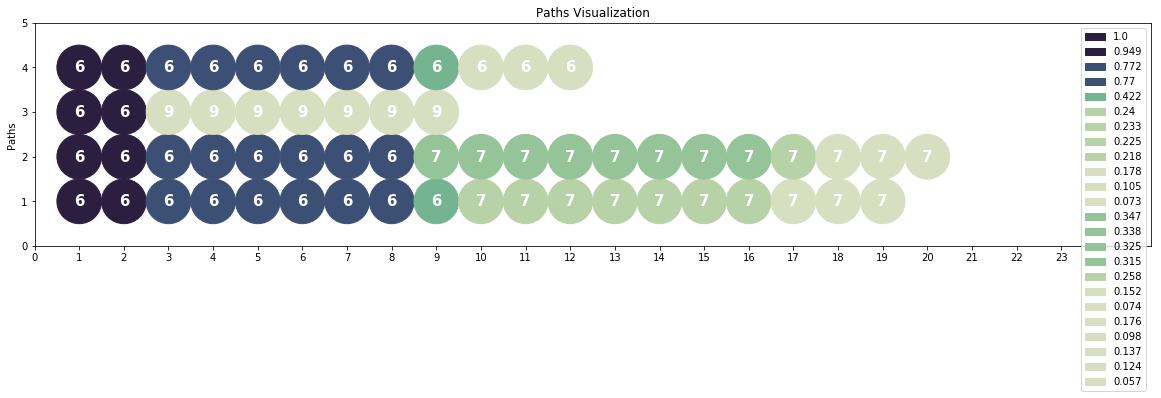

In [6]:
# predicted paths with probabilities
import numpy as np
from collections import OrderedDict
import ipywidgets as widgets
import seaborn as sns
import pandas as pd
import math
import warnings
from queue import PriorityQueue
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None


def add_parent():
    global path
    
    # print("add_parent entered")
    path = path.sort_values(['PathId', 'Hour', 'Prob'])
    path = path.reset_index(drop=True)
    start_hour = hour + 1
    prev_path_id = path.loc[0, 'PathId']
    path1 = pd.DataFrame()
    row = 0

    for i in range(1, len(path)):
        if prev_path_id != path.loc[i, 'PathId']:
            prev_path_id = path.loc[i, 'PathId']
            if path.loc[i, 'Hour'] != hour:

                # look for parents
                fromState = path.loc[i, 'FromState']
                fromHour = path.loc[i, 'FromHour']
                fromProb = path.loc[i, 'FromProb']
                search_till = i
                Hour = path.loc[i, 'Hour']

                while Hour != start_hour:
                    StateId, Hour, Prob, FromState, FromHour, FromProb, j = find_parent(fromState,
                                                                                        fromHour, fromProb, search_till)

                    path1.loc[row, 'StateId'] = StateId
                    path1.loc[row, 'Prob'] = Prob
                    path1.loc[row, 'Hour'] = Hour
                    path1.loc[row, 'FromState'] = FromState
                    path1.loc[row, 'FromHour'] = FromHour
                    path1.loc[row, 'FromProb'] = FromProb
                    path1.loc[row, 'PathId'] = path.loc[i, 'PathId']
                    row = row + 1

                    # look for parents
                    fromState = FromState
                    fromHour = FromHour
                    fromProb = FromProb
                    search_till = j
    path = path.append(path1)
    path = path.sort_values(['PathId', 'Hour', 'Prob'])
    path = path.reset_index(drop=True)


def find_parent(fromState, fromHour, fromProb, search_till):
    
    # print("find_parent entered")
    for j in range(0, search_till):
        if (path.loc[j, 'StateId'] == fromState and
                path.loc[j, 'Hour'] == fromHour and
                path.loc[j, 'Prob'] == fromProb):
            StateId = path.loc[j, 'StateId']
            Hour = path.loc[j, 'Hour']
            Prob = path.loc[j, 'Prob']
            FromState = path.loc[j, 'FromState']
            FromHour = path.loc[j, 'FromHour']
            FromProb = path.loc[j, 'FromProb']

            return StateId, Hour, Prob, FromState, FromHour, FromProb, j


def path_vis():
    global path
    
    # print("path_vis entered")
    # this function draw circles and visualize all paths found
    cmap = sns.cubehelix_palette(10, start=.5, rot=-.75, reverse=True)
    path = path.sort_values(['PathId', 'Hour', 'Prob'])
    path = path.reset_index(drop=True)
    # create a new graph where we will later add rectangles for each hour:cluster
    fig2 = plt.figure(figsize=(20, 20))
    ax1 = fig2.add_subplot(111, aspect='equal')
    
    ax1.set_xticks(np.arange(0, 24, 1))
    limsx = (0, 25)
    limsy = (0, path['PathId'].nunique() + 1)

    path_counter = 1
    prev_path = path.loc[0, 'PathId']

    for i in range(0, len(path)):
        if prev_path != path.loc[i, 'PathId']:
            prev_path = path.loc[i, 'PathId']
            path_counter = path_counter + 1

        x = path.loc[i, 'Hour']
        y = path_counter
        color = pick_col(cmap, path.loc[i, 'Prob'])
        circ = Circle((x, y), radius=0.5, color=color, label=round(path.loc[i, 'Prob'], 3))
        ax1.add_patch(circ)
        ax1.annotate(str(int(path.loc[i, 'StateId'])), (x, y),
                     color='w', weight='bold', fontsize=15, ha='center', va='center')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.ylabel('Paths')
    plt.title('Paths Visualization')
    plt.xlim(limsx)
    plt.ylim(limsy)
    plt.show()


def pick_col(cmap, prob):
    
    # print("pick_col entered")
    intervals = (1 - confidence_thrshld) / 10
    if (prob <= 1) and (prob >= 1 - intervals):
        color = cmap[0]
    elif (prob < 1 - intervals) and (prob >= 1 - 2 * intervals):
        color = cmap[1]
    elif (prob < 1 - 2 * intervals) and (prob >= 1 - 3 * intervals):
        color = cmap[2]
    elif (prob < 1 - 3 * intervals) and (prob >= 1 - 4 * intervals):
        color = cmap[3]
    elif (prob < 1 - 4 * intervals) and (prob >= 1 - 5 * intervals):
        color = cmap[4]
    elif (prob < 1 - 5 * intervals) and (prob >= 1 - 6 * intervals):
        color = cmap[5]
    elif (prob < 1 - 6 * intervals) and (prob >= 1 - 7 * intervals):
        color = cmap[6]
    elif (prob < 1 - 7 * intervals) and (prob >= 1 - 8 * intervals):
        color = cmap[7]
    elif (prob < 1 - 8 * intervals) and (prob >= 1 - 9 * intervals):
        color = cmap[8]
    else:
        color = cmap[9]
    return color


def meters(lat1, lon1, lat2, lon2):
    
    # print("meters entered")
    R = 6378.137  # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat / 2) * math.sin(dLat / 2) + math.cos(lat1 * math.pi / 180) * math.cos(
        lat2 * math.pi / 180) * math.sin(dLon / 2) * math.sin(dLon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c
    return d * 1000  # meters


def add_in_queue(prob, states, hour, from_state, from_hour, from_prob):
    global q
    
    # print("add_in_queue entered")
    size = prob.size
    for i in range(0, size):
        q.put((1 - prob[0][i], states[i], prob[0][i], hour, from_state, from_hour, from_prob))


def print_q():
    while not q.empty():
        next_item = q.get()
        print(next_item)


def assign_paths():
    global path
    
    # print("assign_paths entered")
    path.loc[0, 'PathId'] = 1

    for i in range(1, len(path)):
        # continuation of a path
        if ((path.loc[i, 'Hour'] == path.loc[i - 1, 'Hour'] + 1) and
                (path.loc[i, 'FromState'] == path.loc[i - 1, 'StateId']) and
                (path.loc[i, 'FromHour'] == path.loc[i - 1, 'Hour']) and
                (path.loc[i, 'FromProb'] == path.loc[i - 1, 'Prob'])):
            path.loc[i, 'PathId'] = path.loc[i - 1, 'PathId']
        # new path
        else:
            path_id = 0
            row_count = 0
            # look for parent
            for j in range(0, i):
                row_count = row_count + 1
                if (path.loc[j, 'StateId'] == path.loc[i, 'FromState'] and
                        path.loc[j, 'Hour'] == path.loc[i, 'FromHour'] and
                        path.loc[j, 'Prob'] == path.loc[i, 'FromProb']):
                    path_id = path.loc[j, 'PathId']
                    break
            for j in range(0, i):
                if (path.loc[j, 'FromState'] == path.loc[i, 'FromState'] and
                        path.loc[j, 'FromHour'] == path.loc[i, 'FromHour'] and
                        path.loc[j, 'FromProb'] == path.loc[i, 'FromProb']):
                    path_id = 0

            if path_id != 0:
                # if it is still continuation of an old path
                if path.loc[row_count - 1, 'PathId'] != path.loc[row_count, 'PathId']:
                    path.loc[i, 'PathId'] = path_id
                # new path with existing tail from parent
                else:
                    new_path_id = path['PathId'].max() + 1
                    path.loc[i, 'PathId'] = new_path_id
            else:
                new_path_id = path['PathId'].max() + 1
                path.loc[i, 'PathId'] = new_path_id
    add_parent()


def add_trails():
    global path
    
    if path.empty:
        return
    
    prev_path = path.loc[0, 'PathId']
    tot_states = trained_model_df['StateId'].nunique()
    state_list = trained_model_df['StateId'].unique()
    add_row = 0

    add_points_df = pd.DataFrame()
    add_points_df['StateId'] = 0
    add_points_df['Hour'] = 0
    add_points_df['Prob'] = 0
    add_points_df['FromState'] = 0
    add_points_df['FromHour'] = 0
    add_points_df['FromProb'] = 0

    q.queue.clear()

    for i in range(1, len(path)):

        if (path.loc[i, 'PathId'] != prev_path) or ( i == len(path)-1):

            if path.loc[i, 'PathId'] != prev_path:
                stateid = path.loc[i-1, 'StateId']
                hour = path.loc[i-1, 'Hour']
                prob = path.loc[i-1, 'Prob']
            else:
                stateid = path.loc[i, 'StateId']
                hour = path.loc[i, 'Hour']
                prob = path.loc[i, 'Prob']

            next_hour = hour + 1
            #
            # if the hour has not reached the end already
            if hour != 23:
                next_row = trained_model_df.loc[trained_model_df['StateId'] == stateid]

                from_col_no = int(tot_states * next_hour + 5)
                to_col_no = int(from_col_no + tot_states)
                next_list = next_row.iloc[0:1, from_col_no:to_col_no].as_matrix()

                next_list = next_list * prob
                from_hour = hour
                from_state = stateid
                from_prob = prob
                add_in_queue(next_list, state_list, next_hour, from_state, from_hour, from_prob)
                next_item = q.get()

                # add this to the path list
                add_points_df.loc[add_row, 'StateId'] = next_item[1]
                add_points_df.loc[add_row, 'Prob'] = next_item[2]
                add_points_df.loc[add_row, 'Hour'] = next_item[3]
                add_points_df.loc[add_row, 'FromState'] = next_item[4]
                add_points_df.loc[add_row, 'FromHour'] = next_item[5]
                add_points_df.loc[add_row, 'FromProb'] = next_item[6]
                add_points_df.loc[add_row, 'PathId'] = prev_path
                add_row = add_row + 1

                q.queue.clear()

            prev_path = path.loc[i, 'PathId']
            
    path = pd.concat([path, add_points_df], ignore_index=True)
    
def path_conf(lat, lon):
    global path

    # print("path_conf entered")
    tot_states = trained_model_df['StateId'].nunique()
    state_list = trained_model_df['StateId'].unique()
    path_row = 0

    # calculate the next hour
    if hour == 23:
        return
    else:
        nxt_hour = hour + 1
    
    # look for the selected state from dropdown list into user's markov model
    for i in range(0, len(trained_model_df)):

        trn_lat = trained_model_df['AvgLat'][i]
        trn_lon = trained_model_df['AvgLon'][i]
        
        # if the state is found: proceed
        if meters(trn_lat, trn_lon, lat, lon) <= d_thrhld:
            
            # add the next hour content into the priority queue
            from_col_no = tot_states * nxt_hour + 5
            to_col_no = from_col_no + tot_states
            predic_list = trained_model_df.iloc[i:i + 1, from_col_no:to_col_no].as_matrix()
            add_in_queue(predic_list, state_list, nxt_hour, "start", hour, 1)
            
            # continue until the queue is empty
            while not q.empty():
                next_item = q.get()
                
                # proceed if the probability is greater than user confidence input
                if next_item[2] > confidence_thrshld:

                    read_hour = next_item[3]
                    next_row = trained_model_df.loc[trained_model_df['StateId'] == (next_item[1])]

                    if read_hour == 23:
                        next_hour = 0
                    else:
                        next_hour = read_hour + 1

                    from_col_no = tot_states * next_hour + 5
                    to_col_no = from_col_no + tot_states
                    next_list = next_row.iloc[0:1, from_col_no:to_col_no].as_matrix()
                    next_list = next_list * next_item[2]
                    from_hour = next_item[3]
                    from_state = next_item[1]
                    from_prob = next_item[2]
                    
                    # add this to the path list
                    path.loc[path_row, 'StateId'] = next_item[1]
                    path.loc[path_row, 'Prob'] = next_item[2]
                    path.loc[path_row, 'Hour'] = next_item[3]
                    path.loc[path_row, 'FromState'] = next_item[4]
                    path.loc[path_row, 'FromHour'] = next_item[5]
                    path.loc[path_row, 'FromProb'] = next_item[6]
                    path_row = path_row + 1

                    # stop if the hour is already 23
                    if read_hour == 23:
                        continue
                    
                    # add the next hour into the priority queue
                    add_in_queue(next_list, state_list, read_hour + 1, from_state, from_hour, from_prob)
                    
            
            
            # if the path is not empty, attach the complete path to each path till starting hour
            if not path.empty:
                # add next point below threshold for each path
                assign_paths()
                add_trails()
                path_vis()
                path = path.iloc[0:0]
            else:
                path = path.iloc[0:0]
                print("No paths with this confidence threshold found.")
            break


def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        lat = change['new'][1]
        lon = change['new'][2]

        print("User:: " + user + " , Month:: " + month + " ,Known State, Latitude and Longitude:: " + str(change['new'][0]) + ","
              + str(lat) + "," + str(lon) + " at hour " + str(hour))
        path_conf(lat, lon)


# -------------------------------------------------------------------------------------------------------
#                        Change User, Month, Starting hour, Location of Data here
# -------------------------------------------------------------------------------------------------------
user = "012"
src_path = "C:/Users/12sha/Documents/thesislocation/code_/stay points/v0.8 results"
confidence_thrshld = 0.1  # minimum confidence for path predictions
month = "200811"  # model to be used for path predictions
hour = 0

# -------------------------------------------------------------------------------------------------------
#                                       Initialize Variables
# -------------------------------------------------------------------------------------------------------
d_thrhld = 10
q = PriorityQueue()
path = pd.DataFrame()

path['StateId'] = 0
path['Hour'] = 0
path['Prob'] = 0
path['FromState'] = 0
path['FromHour'] = 0
path['FromProb'] = 0

# -------------------------------------------------------------------------------------------------------
#                                       Load User markov Chain Model
# -------------------------------------------------------------------------------------------------------
trained_model_file = src_path + "/User " + user + "/" + month + "/markovchains/final.csv"
file1 = src_path + "/User " + user + "/" + month + "/path_df.csv"
file2 = src_path + "/User " + user + "/" + month + "/path.csv"

trained_model_df = pd.read_csv(trained_model_file, header=0)

dfList = trained_model_df[['StateId', 'AvgLat', 'AvgLon']].values
dfList = dfList.tolist()

# -------------------------------------------------------------------------------------------------------
#                                      Prepare Dropdown list for Available States
# -------------------------------------------------------------------------------------------------------
w1 = widgets.Dropdown(
    options=dfList,
    description='State:',
)

display(w1)
w1.observe(on_change)